In [1]:
import torch
import torch.nn as nn
import cv2 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import os
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
from src.calculate_metrics import F1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
IMG_SIZE = 3500
MAX_PIXEL_VALUE = 255
#TODO calculate for dataset
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

In [3]:
#m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))

class CustomSegmentationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        self.transform = \
        A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            #A.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD, MAX_PIXEL_VALUE),
            ToTensorV2()
        ])
        
        self.image_folder = os.path.join(root_dir, 'images')
        self.mask_folder = os.path.join(root_dir, 'masks')
        self.image_list = list(filter(lambda x: x[-4:] == '.png', sorted(os.listdir(self.image_folder))))
        self.mask_list = list(filter(lambda x: x[-4:] == '.png', sorted(os.listdir(self.mask_folder))))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_list[idx])
        mask_name = os.path.join(self.mask_folder, self.mask_list[idx])  # Assuming masks have the same filenames

        image = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_name), cv2.COLOR_BGR2GRAY)
        
        augmented = self.transform(image=np.array(image), mask=np.array(mask))
        image = augmented['image'].float() / 255.0
        mask = augmented['mask']
        
        return image, mask

dataset = CustomSegmentationDataset(root_dir='train')


/tmp/ipykernel_430124/2507388187.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image[:, mask] = torch.tensor([1, 0, 0], dtype=torch.float32).view(3, 1)


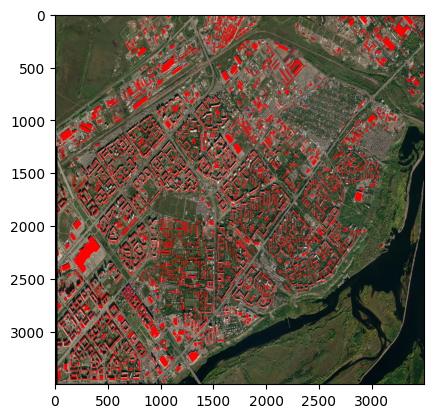

3571

In [4]:
data_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

# Iterate over batches
for batch in data_loader:
    images, masks = batch

    image, mask = images[0], masks[0]
    image[:, mask] = torch.tensor([1, 0, 0], dtype=torch.float32).view(3, 1)
    image_numpy = image.numpy().transpose((1, 2, 0))
    plt.imshow(image_numpy)
    plt.show()
    break
del data_loader
gc.collect()

Train / Validation

In [5]:
import torch
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Model

In [6]:
from src.Unet import UNet

model = UNet(n_channels=3, n_classes=2)
model = nn.DataParallel(model).to(device)

Train

In [7]:
from src.DiceLoss import DiceLoss

optimizer = torch.optim.Adam(
    model.parameters(),
)
criterion1 = nn.CrossEntropyLoss(reduction="mean")
criterion2 = DiceLoss()

In [8]:


def train_model(model, train_loader, val_loader, device, optimizer, epochs=1):
    best_score = 0

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(
            total=len(train_dataset), desc=f"Epoch {epoch}/{epochs}", unit="img"
        ) as pbar:
            for i, batch in enumerate(train_loader):
                images, true_masks = batch
                images, true_masks = images.to(device), true_masks.to(device)
 
                masks_pred = model(images)

                loss = criterion1(masks_pred, true_masks.long()) + criterion2(masks_pred, true_masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(images.shape[0])
                epoch_loss += loss.item()
                pbar.set_description(f"Epoch: {epoch}, avg_loss: {epoch_loss / (i + 1)}")
                
        model.eval()
        f1_metrics = np.array([])
        with tqdm(total=len(val_dataset), desc=f"Validation", unit="img") as pbar:
            with torch.no_grad():
                for i, batch in enumerate(val_loader):
                    images, true_masks = batch

                    images, true_masks = images.to(device), true_masks.to(device)

                    masks_pred = model(images.float())
                    predictions = torch.argmax(masks_pred, dim = 1)
                    pbar.update(images.shape[0])
                    f1_metrics = np.append(f1_metrics, F1(true_masks, predictions).cpu().numpy())


        print(f'F1 score: {f1_metrics.mean()}')
        
        if f1_metrics.mean() > best_score:
            best_score = f1_metrics.mean()
            torch.save(model.state_dict(), "best.pt")

In [9]:
train_model(model, train_loader, val_loader, device, optimizer, epochs=30)

Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.1339239627122879


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.1606681004166603


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.0870005764067173


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.17914297431707382


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.27430319488048555


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.4495327591896057


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.4624580264091492


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.3583524614572525


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.55s/img]


F1 score: 0.35262802243232727


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.56s/img]


F1 score: 0.38832107186317444


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.48436891436576845


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.4209381461143494


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.49887227416038515


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.41s/img]


F1 score: 0.41672167778015134


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.3541727900505066


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.5236263751983643


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.4873479902744293


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.38874395191669464


Validation: 100%|██████████| 5/5 [00:08<00:00,  1.66s/img]


F1 score: 0.4956887185573578


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.5154154241085053


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.4970583200454712


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.33005366325378416


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.48547565937042236


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.3437964469194412


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.4676962584257126


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.43s/img]


F1 score: 0.5160992205142975


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.45421921014785765


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.5286289095878601


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.42s/img]


F1 score: 0.4683491885662079


Validation: 100%|██████████| 5/5 [00:07<00:00,  1.41s/img]

F1 score: 0.51202312707901


In [10]:
model.load_state_dict(torch.load('best.pt'))

<All keys matched successfully>

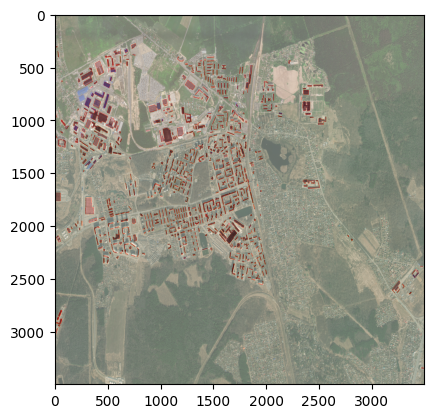

<Figure size 640x480 with 0 Axes>

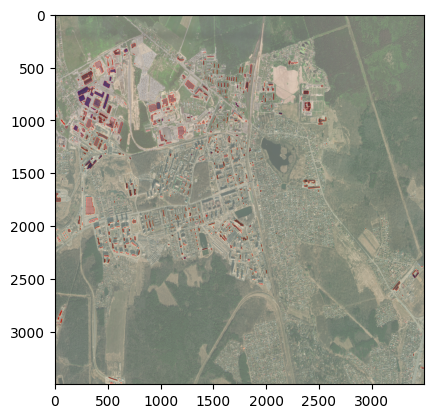

In [22]:
# Iterate over batches
i = 0
for batch in val_loader:
    images, masks = batch
    fig = plt.figure()
    image, mask = images[0], masks[0]
    image_numpy = image.numpy().transpose((1, 2, 0))
    
    plt.imshow(image_numpy)
    plt.imshow(mask.numpy(), alpha=0.4, cmap='Reds')
    plt.show()
    fig.savefig('figure_real.png', dpi=500, bbox_inches='tight')
    plt.clf()
    # Image.fromarray(image_numpy).save(f'images/{i}.png')
    # Image.fromarray(mask.cpu().numpy()).save(f'real_masks/{i}.png')
    
    images = images.to(device)
    masks_pred = model(images.float())
    masks_pred = torch.argmax(masks_pred, dim = 1)
    image, mask = images[0], masks_pred[0]
    
    fig = plt.figure()
    plt.imshow(image_numpy)
    plt.imshow(mask.cpu().numpy(), alpha=0.4, cmap='Reds')
    plt.show()
    fig.savefig('figure_predicted.png', dpi=500, bbox_inches='tight')
    
    # Image.fromarray(mask.cpu().numpy()).save(f'predicted_masks/{i}.png')
    break